<a href="https://colab.research.google.com/github/venezianof/booksum/blob/main/module-6/assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assistants

[Assistants](https://langchain-ai.github.io/langgraph/concepts/assistants/#resources) give developers a quick and easy way to modify and version agents for experimentation.

## Supplying configuration to the graph

Our `task_maistro` graph is already set up to use assistants!

It has a `configuration.py` file defined and loaded in the graph.

We access configurable fields (`user_id`, `todo_category`, `task_maistro_role`) inside the graph nodes.

## Creating assistants

Now, what is a practical use-case for assistants with the `task_maistro` app that we've been building?

For me, it's the ability to have separate ToDo lists for different categories of tasks.

For example, I want one assistant for my personal tasks and another for my work tasks.

These are easily configurable using the `todo_category` and `task_maistro_role` configurable fields.

![Screenshot 2024-11-18 at 9.35.55 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/673d50597f4e9eae9abf4869_Screenshot%202024-11-19%20at%206.57.01%E2%80%AFPM.png)

### Esempio 1: Grafico a Linee (Line Plot)

Utile per mostrare l'andamento di una variabile nel tempo o in relazione a un'altra variabile continua.

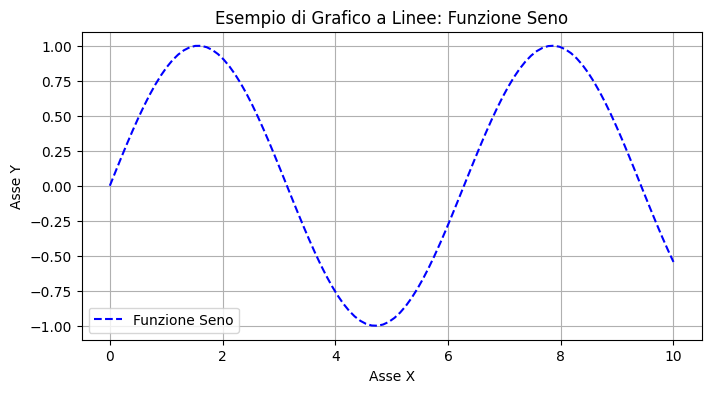

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dati di esempio
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Creazione del grafico a linee
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Funzione Seno', color='blue', linestyle='--')
plt.title('Esempio di Grafico a Linee: Funzione Seno')
plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.grid(True)
plt.legend()
plt.show()

### Esempio 2: Grafico a Dispersione (Scatter Plot)

Ideale per visualizzare la relazione tra due variabili numeriche e identificare pattern o correlazioni.

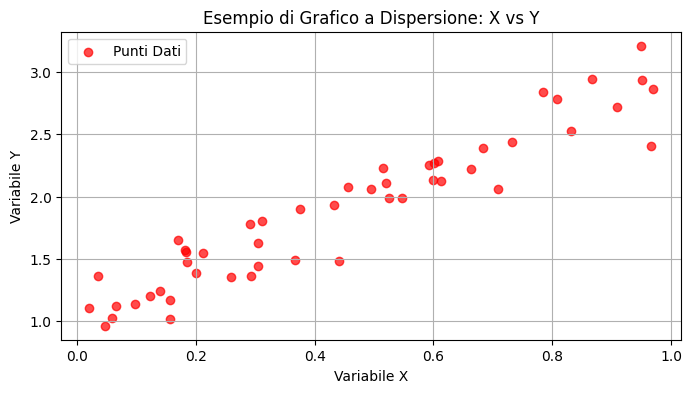

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Dati di esempio (generazione casuale)
np.random.seed(42)
x = np.random.rand(50)
y = 2 * x + 1 + np.random.randn(50) * 0.2 # Relazione lineare con rumore

# Creazione del grafico a dispersione
plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', alpha=0.7, marker='o', label='Punti Dati')
plt.title('Esempio di Grafico a Dispersione: X vs Y')
plt.xlabel('Variabile X')
plt.ylabel('Variabile Y')
plt.grid(True)
plt.legend()
plt.show()

### Esempio 3: Grafico a Barre (Bar Chart)

Utilizzato per confrontare quantità tra diverse categorie discrete.

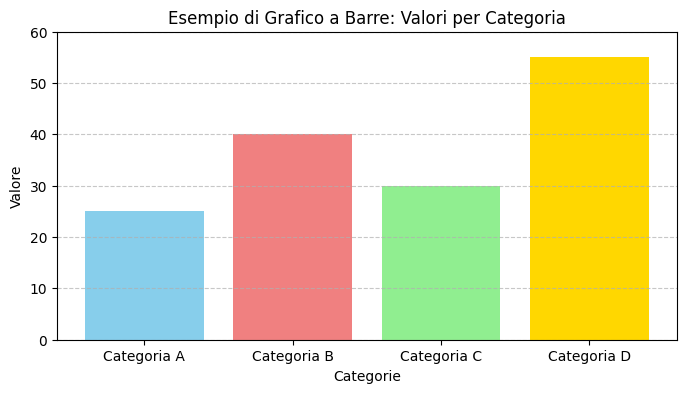

In [3]:
import matplotlib.pyplot as plt

# Dati di esempio
categorie = ['Categoria A', 'Categoria B', 'Categoria C', 'Categoria D']
valori = [25, 40, 30, 55]

# Creazione del grafico a barre
plt.figure(figsize=(8, 4))
plt.bar(categorie, valori, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Esempio di Grafico a Barre: Valori per Categoria')
plt.xlabel('Categorie')
plt.ylabel('Valore')
plt.ylim(0, 60) # Imposta il limite massimo dell'asse Y per una migliore visualizzazione
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
%%capture --no-stderr
%pip install -U langgraph_sdk

This is the default assistant that we created when we deployed the graph.

In [ ]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)

### Personal assistant

This is the personal assistant that I'll use to manage my personal tasks.

In [ ]:
personal_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro",
    config={"configurable": {"todo_category": "personal"}}
)
print(personal_assistant)

ConnectError: All connection attempts failed

In [ ]:
!curl http://localhost:8123/healthz

curl: (7) Failed to connect to localhost port 8123 after 0 ms: Connection refused


In [ ]:
from langgraph_sdk import get_client

   # Assuming your server is running at http://localhost:8123
   url_for_cli_deployment = "http://localhost:8123"

   # Use await when calling get_client
   client = await get_client(url=url_for_cli_deployment)

   # The rest of your code follows...

IndentationError: unexpected indent (<ipython-input-22-b812ed78868a>, line 4)

In [ ]:
import os
    url_for_cli_deployment = os.environ.get("LANGGRAPH_URL", "your_cloud_url")

IndentationError: unexpected indent (<ipython-input-23-de48d4d1bb17>, line 2)

In [ ]:
import os
# If using a cloud deployment, uncomment the following line and replace with your cloud URL
url_for_cli_deployment = os.environ.get("LANGGRAPH_URL", "your_cloud_url")
# url_for_cli_deployment = "http://localhost:8123"  # For local deployments

# Print the URL for verification
print(f"Connecting to: {url_for_cli_deployment}")

client = await get_client(url=url_for_cli_deployment)

# ... rest of your code

# Deleting an assistant (example for work_assistant)
await client.assistants.delete(work_assistant_id)

Connecting to: your_cloud_url


TypeError: object LangGraphClient can't be used in 'await' expression

In [ ]:
import os
# If using a cloud deployment, uncomment the following line and replace with your cloud URL
url_for_cli_deployment = os.environ.get("LANGGRAPH_URL", "your_cloud_url")
# url_for_cli_deployment = "http://localhost:8123"  # For local deployments

# Print the URL for verification
print(f"Connecting to: {url_for_cli_deployment}")

client = await get_client(url=url_for_cli_deployment)

# ... rest of your code

# Deleting an assistant (example for work_assistant)
await client.assistants.delete(work_assistant_id)

Connecting to: your_cloud_url


TypeError: object LangGraphClient can't be used in 'await' expression

In [ ]:
import os

# If using a cloud deployment, uncomment the following line and replace with your cloud URL
# url_for_cli_deployment = os.environ.get("LANGGRAPH_URL", "your_cloud_url")
url_for_cli_deployment = "http://localhost:8123"  # For local deployments

# Add this line to print the URL for verification
print(f"Connecting to: {url_for_cli_deployment}")

client = get_client(url=url_for_cli_deployment)

# ... rest of your code

Connecting to: http://localhost:8123


Let's update this assistant to include my `user_id` for convenience, [creating a new version of it](https://langchain-ai.github.io/langgraph/cloud/how-tos/assistant_versioning/#create-a-new-version-for-your-assistant).

In [ ]:
!pip install langgraph_sdk

In [ ]:
from langgraph_sdk import get_client

   # Replace 'your_cloud_url' or 'http://localhost:8123' with your actual deployment URL.
   url_for_cli_deployment = "your_cloud_url"  # Or "http://localhost:8123" for local deployments
   client = await get_client(url=url_for_cli_deployment)

IndentationError: unexpected indent (<ipython-input-30-ed85ff3de0eb>, line 4)

In [ ]:
# Assuming you know the assistant ID
   openai_assistant = await client.assistants.get("your_existing_assistant_id")

IndentationError: unexpected indent (<ipython-input-31-848f12df28f3>, line 2)

In [ ]:
openai_assistant_v2 = await client.assistants.update(
       openai_assistant['assistant_id'],
       config={"configurable": {"model_name": "openai", "system_prompt": "You are a helpful assistant!"}}
   )
   print(openai_assistant_v2)  # To see the updated assistant details

IndentationError: unexpected indent (<ipython-input-32-8ffecd85aab3>, line 5)

In [ ]:
task_maistro_role = """You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:

- Help track and organize personal tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- Proactively ask for deadlines when new tasks are added without them
- Maintain a supportive tone while helping the user stay accountable
- Help prioritize tasks based on deadlines and importance

Your communication style should be encouraging and helpful, never judgmental.

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Would you like to add one to help us track it better?"""

configurations = {"todo_category": "personal",
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

personal_assistant = await client.assistants.update(
    personal_assistant["assistant_id"],
    config={"configurable": configurations}
)
print(personal_assistant)

NameError: name 'personal_assistant' is not defined

### Work assistant

Now, let's create a work assistant. I'll use this for my work tasks.

In [ ]:
task_maistro_role = """You are a focused and efficient work task assistant.

Your main focus is helping users manage their work commitments with realistic timeframes.

Specifically:

- Help track and organize work tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:
  • Developer Relations features: typically 1 day
  • Course lesson reviews/feedback: typically 2 days
  • Documentation sprints: typically 3 days
- Help prioritize tasks based on deadlines and team dependencies
- Maintain a professional tone while helping the user stay accountable

Your communication style should be supportive but practical.

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Based on similar tasks, this might take [suggested timeframe]. Would you like to set a deadline with this in mind?"""

configurations = {"todo_category": "work",
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

work_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro",
    config={"configurable": configurations}
)
print(work_assistant)

ConnectError: All connection attempts failed

In [ ]:
!curl http://localhost:8123/healthz

## Using assistants

Assistants will be saved to `Postgres` in our deployment.  

This allows us to easily search [search](https://langchain-ai.github.io/langgraph/cloud/how-tos/configuration_cloud/) for assistants with the SDK.

In [ ]:
# Assume state and config are defined
updated_state = call_model(state, config)

# Access the generated response
response_message = updated_state["messages"][0]

# ... further processing of response_message ...

NameError: name 'call_model' is not defined

In [ ]:
from langgraph_sdk import get_client

client = get_client(url="your_deployment_url")  # Replace with your URL
assistants = await client.assistants.search()
assistant = [a for a in assistants if not a["config"]][0]

print(assistant)  # To see the details of the selected assistant

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

In [ ]:
assistants = await client.assistants.search()
for assistant in assistants:
    print({
        'assistant_id': assistant['assistant_id'],
        'version': assistant['version'],
        'config': assistant['config']
    })

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

We can manage them easily with the SDK. For example, we can delete assistants that we're no longer using.

In [ ]:
await client.assistants.delete("assistant_id")

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

In [ ]:
print(f"Connecting to: {url_for_cli_deployment}")
   client = get_client(url=url_for_cli_deployment)

Let's set the assistant IDs for the `personal` and `work` assistants that I'll work with.

In [ ]:
work_assistant_id = assistants[0]['assistant_id']
personal_assistant_id = assistants[1]['assistant_id']

### Work assistant

Let's add some ToDos for my work assistant.

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import convert_to_messages

user_input = "Create or update few ToDos: 1) Re-film Module 6, lesson 5 by end of day today. 2) Update audioUX by next Monday."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"],
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

In [ ]:
user_input = "Create another ToDo: Finalize set of report generation tutorials."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"],
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

The assistant uses it's instructions to push back with task creation!

It asks me to specify a deadline :)

In [ ]:
user_input = "OK, for this task let's get it done by next Tuesday."
async for chunk in client.runs.stream(thread["thread_id"],
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

NameError: name 'thread' is not defined

### Personal assistant

Similarly, we can add ToDos for my personal assistant.

In [ ]:
user_input = "Create ToDos: 1) Check on swim lessons for the baby this weekend. 2) For winter travel, check AmEx points."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"],
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.

In [ ]:
user_input = "Give me a todo summary."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"],
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

UnsupportedProtocol: Request URL is missing an 'http://' or 'https://' protocol.